# **Helping the Human Resources**

# Summary

<div class="alert alert-block alert-success">
<b>"Saliford Motors": a ficticious enterprise.</b>

This project regards Saliford Motors, and was part of an exercise in a Google Analytics course. A data set, containing information about employees in the imaginary "Saliford Motors" company is provided. The goal is to gather insights about the workers condition at the company, to be presented to their HR department.
<b>Can we predict which employees will leave</b> Saliford Motors? Can we help the HR department to understand why people are leaving in the first place?
    
***
A XGBoost model trained on 75% of the data yields an F1 score of 0.95, precision of 0.98 and recall of 0.92 for predictions of which employees leave.
    
<b>Employees apparently leave Salisford Motors because of:</b>
* Lack of satisfaction
* Large number of projects and number of years at company
* Extreme workload may be required for good evaluations
    
This workplace is likely toxic and/or burnout-inducing.

## Import packages, load data

In [108]:
# Import packages
### GENERAL PACKAGES
import numpy as np, pandas as pd

### SPECIFIC USAGE
import itertools as iter

### PLOTTING
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.tree import plot_tree

### PRE-PROCESSING
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### VALIDATION
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit

### MODELS
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### EXPORTING MODELS
import pickle

# LOAD DATASET
df0 = pd.read_csv("HR_capstone_dataset.csv")

In [109]:
# INSPECT DATASET
df0.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


## General Inspection of data

In [110]:
# SHAPE, DATA TYPES
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [111]:
# DATASET OVERVIEW
df0.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


In [112]:
# COLUMN FEATURES ARE TOO LONG, AND MESSY
df0.rename(columns = {'number_project' : 'projects', 'average_montly_hours' : 'av_hours_month', 
                      'last_evaluation' : 'evaluation', 'satisfaction_level' : 'satisfaction', 
                      'time_spend_company' : 'tenure', 'Work_accident' : 'work_accident', 
                      'promotion_last_5years' : 'promotion', 'Department' : 'department'}, inplace=True)
# DISPLAY NEW FEATURE NAMES
df0.columns

Index(['satisfaction', 'evaluation', 'projects', 'av_hours_month', 'tenure',
       'work_accident', 'left', 'promotion', 'department', 'salary'],
      dtype='object')

In [113]:
# DIFFERENT CATEGORIES IN CATEGORICAL FEATURES
print("Categories in DEPARTMENT:", df0.department.unique())
print("Categories in SALARY:", df0.salary.unique())

Categories in DEPARTMENT: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']
Categories in SALARY: ['low' 'medium' 'high']


In [114]:
# CHECK FOR MISSING ENTRIES
print('Number of missing entries:', df0.isna().any(axis=1).sum())
# CHECK FOR DUPLICATE ENTRIES
print('Number of duplicated entries:', df0.duplicated().sum())

Number of missing entries: 0
Number of duplicated entries: 3008


In [115]:
# DISPLAY SOME OF THE DUPLICATED ROWS (KEEP=FALSE SHOWS ALL DUPLICATES)
# SORTING AV_HOURS_MONTH ALLOWS FOR A FINE-GRAINING OF RESULTS, SHOWING MOST DUPLICATES SIDE-BY-SIDE 
df0[df0.duplicated(keep=False)].sort_values(by='av_hours_month')

,satisfaction,evaluation,projects,av_hours_month,tenure,work_accident,left,promotion,department,salary
13401,0.28,0.89,4,97,6,0,0,0,management,low
11190,0.28,0.89,4,97,6,0,0,0,management,low
10848,0.83,0.86,4,98,4,0,0,0,sales,low
10809,0.51,0.74,6,98,3,0,0,0,support,low
13020,0.51,0.74,6,98,3,0,0,0,support,low
...,...,...,...,...,...,...,...,...,...,...
14972,0.11,0.97,6,310,4,0,1,0,accounting,medium
14777,0.11,0.79,7,310,4,0,1,0,hr,low
1936,0.11,0.97,6,310,4,0,1,0,accounting,medium
12566,0.11,0.79,7,310,4,0,1,0,hr,low


<div class='alert alert-block alert-warning'>
<b>Duplicates and missing data:</b>
    
* 14999x10 dataset entries; two categorical fields (DEPARTMENT, SALARY), eight numerical
    * of the numerical ones, three are also categorical (binary; PROMOTION, LEFT, WORK_ACCIDENT)
* There are no missing data entries
* there are 3008 duplicated entries (not counting the original entry)
    * we could ask Saliford Motors about duplicates, there could be a problem with their data collection processes
        * but Saliford Motors doesn't exist, so we won't ask
        * we'll remove all duplicates instead
</div>

In [116]:
# DROP DUPLICATES
df1 = df0.drop_duplicates()

## Distributions, check for outliers

<ipython-input-117-bc5a75f293fc>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


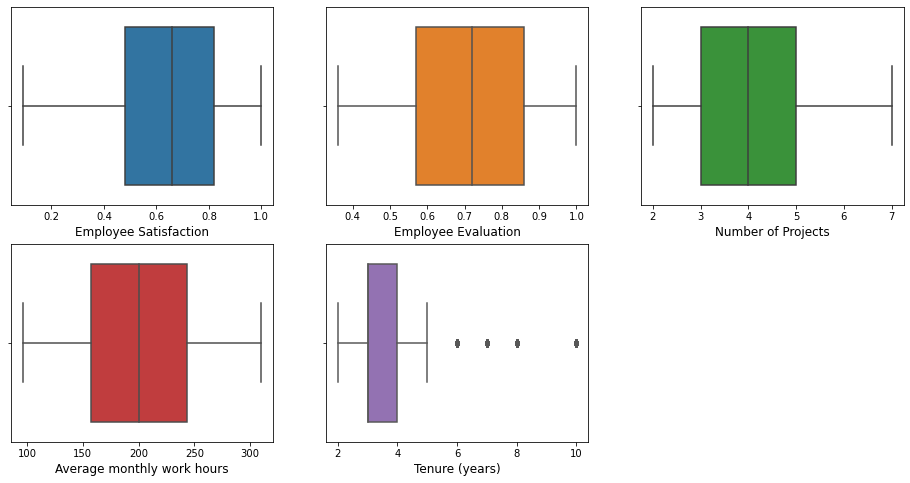

In [117]:
# ONE-DIMENSIONAL DISTRIBUTIONS
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (16,8))
gs = plt.GridSpec(2,3, height_ratios=(1,1))

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])

# SET COLOR PALETTE
palette = iter.cycle(sns.color_palette())    

ax1 = sns.boxplot(ax=g1, data = df1, x='satisfaction',color=next(palette))
ax1.set_xlabel('Employee Satisfaction', fontsize=12)
#ax1.set_ylabel('Number of passengers', fontsize=12)

ax2 = sns.boxplot(ax=g2, data = df1, x='evaluation',color=next(palette))
ax2.set_xlabel('Employee Evaluation', fontsize=12)
#ax2.set_ylabel('Number of passengers', fontsize=12)

ax3 = sns.boxplot(ax=g3, data = df1, x='projects',color=next(palette))
ax3.set_xlabel('Number of Projects', fontsize=12)
#ax3.set_ylabel('Number of passengers', fontsize=12)

ax4 = sns.boxplot(ax=g4, data = df1, x='av_hours_month',color=next(palette))
ax4.set_xlabel('Average monthly work hours', fontsize=12)
#ax4.set_ylabel('Number of passengers', fontsize=12)

ax5 = sns.boxplot(ax=g5, data = df1, x='tenure',color=next(palette))
ax5.set_xlabel('Tenure (years)', fontsize=12)
#ax5.set_ylabel('Number of passengers', fontsize=12)
fig.show()

In [118]:
# FUNCTION TO DETERMINE HOW MANY OUTLIERS THERE ARE, WHICH FEATURES HAVE THEM
# AND WHETHER TO REMOVE THEM OR NOT
def remove_outliers(data, column_list:list, q_mult:float=1.6, remove:str='n'):
    '''
    COLUMN_LIST is a list of column headers in DATA. Q_MULT is a float (defaults to 1.6).
    REMOVE is a string controlling whether to remove the outliers.
    If REMOVE is set to 'y', the function should be assigned to a variable.
    Identifies outliers in COLUMN_LIST columns of DATA dataframe by:
            outlier < q2 - Q_MULT * iqr | q3 + Q_MULT * iqr < outlier
    where iqr is the interquartile range q3-q2.
    Asks whether to remove all rows in dataframe with outliers in the selected columns.
    '''    
    # CREATE LIST OF DATAFRAME INDEXES CONTAINING OUTLIERS IN THE GIVEN COLUMNS
    outlier_rows = []    
    # RUN THROUGH COLUMN_LIST FEATURES
    for col in column_list:
        # CALCULATE Q2 & Q3 FOR EACH FEATURE
        q2 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        # CALCULATE IQR AND UPPE/LOWER LIMITS FOR DATA
        iqr = q3 - q2
        upper_limit = q3 + q_mult*iqr
        lower_limit = q2 - q_mult*iqr
        print('Upper limit for feature '+ col + ':', upper_limit)
        print('Lower limit for feature '+ col + ':', lower_limit)
        # IDENTIFY OUTLIERS
        outliers = data[(data[col] < lower_limit) | (data[col] > upper_limit)]
        print('Number of outliers in feature '+ col + ':', len(outliers),'\n')
        # GET OUTLIER INDEXES
        outliers_index = data.index[(data[col] < lower_limit) | (data[col] > upper_limit)].tolist()
        if outliers_index != []:
            outlier_rows += outliers_index
    outlier_list = np.unique(outlier_rows)
    print('Total number of rows with outliers:', len(outlier_list))
    if remove == 'y':
        df = data.drop(index=outlier_list, axis=0)
        return df

In [119]:
remove_outliers(df1, df1.columns[:5])

Upper limit for feature satisfaction: 1.3639999999999999
Lower limit for feature satisfaction: -0.06399999999999995
Number of outliers in feature satisfaction: 0 

Upper limit for feature evaluation: 1.324
Lower limit for feature evaluation: 0.10599999999999987
Number of outliers in feature evaluation: 0 

Upper limit for feature projects: 8.2
Lower limit for feature projects: -0.20000000000000018
Number of outliers in feature projects: 0 

Upper limit for feature av_hours_month: 380.6
Lower limit for feature av_hours_month: 19.400000000000006
Number of outliers in feature av_hours_month: 0 

Upper limit for feature tenure: 5.6
Lower limit for feature tenure: 1.4
Number of outliers in feature tenure: 824 

Total number of rows with outliers: 824


In [120]:
df_nofliers = remove_outliers(df1, df1.columns[:5], remove='y')
print('DataFrame dimensions before:', df1.shape)
print('DataFrame dimensions now:', df_nofliers.shape)

Upper limit for feature satisfaction: 1.3639999999999999
Lower limit for feature satisfaction: -0.06399999999999995
Number of outliers in feature satisfaction: 0 

Upper limit for feature evaluation: 1.324
Lower limit for feature evaluation: 0.10599999999999987
Number of outliers in feature evaluation: 0 

Upper limit for feature projects: 8.2
Lower limit for feature projects: -0.20000000000000018
Number of outliers in feature projects: 0 

Upper limit for feature av_hours_month: 380.6
Lower limit for feature av_hours_month: 19.400000000000006
Number of outliers in feature av_hours_month: 0 

Upper limit for feature tenure: 5.6
Lower limit for feature tenure: 1.4
Number of outliers in feature tenure: 824 

Total number of rows with outliers: 824
DataFrame dimensions before: (11991, 10)
DataFrame dimensions now: (11167, 10)


<div class='alert alert-block alert-info'>
<b>Outliers:</b>

* 824 entries were removed due to having outliers in the TENURE feature
* dataset is now 11167x10 large
</div>

## EDA

<ipython-input-121-32b56bae94ea>:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


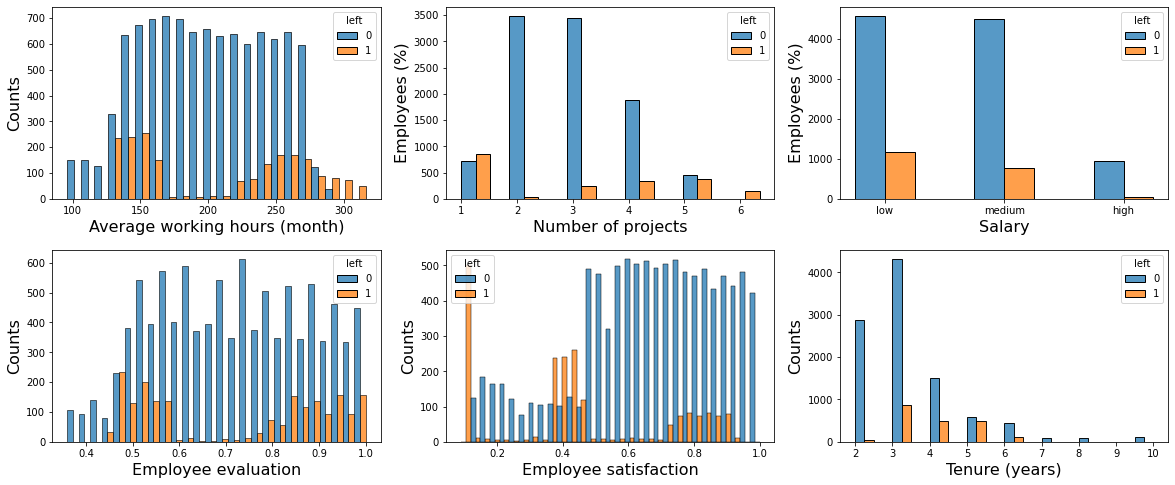

In [121]:
# ONE-DIMENSIONAL DISTRIBUTIONS
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (20,16))
gs = plt.GridSpec(3,3, height_ratios=(1,1,2))

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])
g6 = plt.subplot(gs[1, 2])

ax1 = sns.histplot(ax=g1, data = df1, x='av_hours_month',hue = 'left', stat='count', multiple='dodge', binwidth=10)
ax1.set_xlabel('Average working hours (month)', fontsize=16)
ax1.set_ylabel('Counts', fontsize=16)

ax2 = sns.histplot(ax=g2, data = df1, x='projects',hue = 'left', stat='count', multiple='dodge',shrink=3)
ax2.set_ylabel('Employees (%)', fontsize=16)
ax2.set_xlabel('Number of projects', fontsize=16)

ax3 = sns.histplot(ax=g3, data = df1, x='salary',hue = 'left', stat='count', multiple='dodge',shrink=0.5)
ax3.set_ylabel('Employees (%)', fontsize=16)
ax3.set_xlabel('Salary', fontsize=16)

ax4 = sns.histplot(ax=g4, data = df1, x='evaluation',hue = 'left', stat='count', multiple='dodge')
ax4.set_ylabel('Counts', fontsize=16)
ax4.set_xlabel('Employee evaluation', fontsize=16)

ax5 = sns.histplot(ax=g5, data = df1, x='satisfaction',hue = 'left', stat='count', multiple='dodge')
ax5.set_ylabel('Counts', fontsize=16)
ax5.set_xlabel('Employee satisfaction', fontsize=16)

ax6 = sns.histplot(ax=g6, data = df1, x='tenure',hue = 'left', stat='count', multiple='dodge', binwidth=0.5)
ax6.set_ylabel('Counts', fontsize=16)
ax6.set_xlabel('Tenure (years)', fontsize=16)

fig.show()

<div class="alert alert-block alert-success">
<b>Univariate distributions:</b>
    
* Work hours, evaluation and satisfaction are similarly stratified.
* Most workers are assigned three or four projects; those assigned seven projects leave. Three projects is best.
* Most workers have short tenures and low/medium salaries; those with larger tenure/salary rarely leave.
</div>

<ipython-input-122-f0d087ebae9d>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


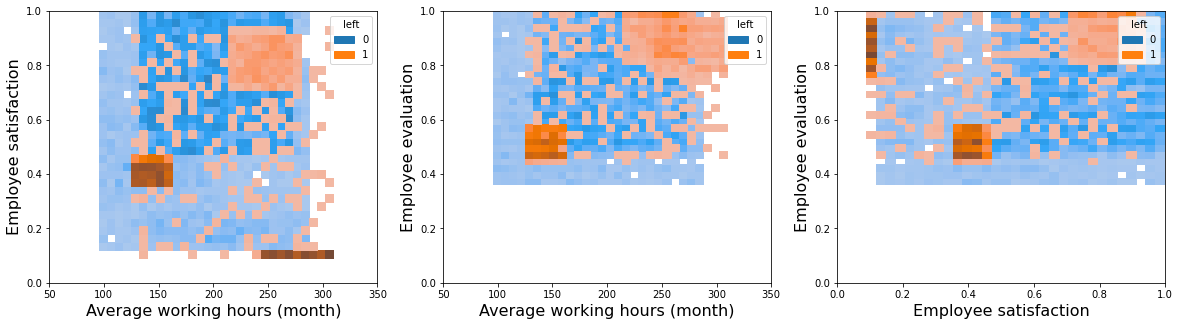

In [122]:
# WORKING HOURS, SATISFACTION, EVALUATION
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (20,5))
gs = plt.GridSpec(1,3)

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])

ax1 = sns.histplot(ax=g1, data = df1, x='av_hours_month', y = 'satisfaction', hue = 'left')
ax1.set_xlabel('Average working hours (month)', fontsize=16)
ax1.set_ylabel('Employee satisfaction', fontsize=16)
ax1.set_ylim(0,1), ax1.set_xlim(50,350)

ax2 = sns.histplot(ax=g2, data = df1, x='av_hours_month', y = 'evaluation', hue = 'left')
ax2.set_xlabel('Average working hours (month)', fontsize=16)
ax2.set_ylabel('Employee evaluation', fontsize=16)
ax2.set_ylim(0,1), ax2.set_xlim(50,350)

ax3 = sns.histplot(ax=g3, data=df1, x='satisfaction', y='evaluation', hue='left')
ax3.set_xlabel('Employee satisfaction', fontsize=16)
ax3.set_ylabel('Employee evaluation', fontsize=16)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

fig.show()

<div class="alert alert-block alert-success">
<b>Working hours, evaluation, satisfaction:</b>
    
* Employees who leave work either much more or much less hours than average of employees that stay.
* Of all employees who leave, those that work more are better evaluated than average, those who work less are worse evaluated.
* The best evaluated (and most working) are divided into very satisfied or very unsatisfied.<br>
</div>

<div class="alert alert-block alert-warning">
<b>Working hours, evaluation, satisfaction:</b>
    
Again, data is tightly grouped for the employees that left.
</div>

<ipython-input-123-0ca30e874527>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


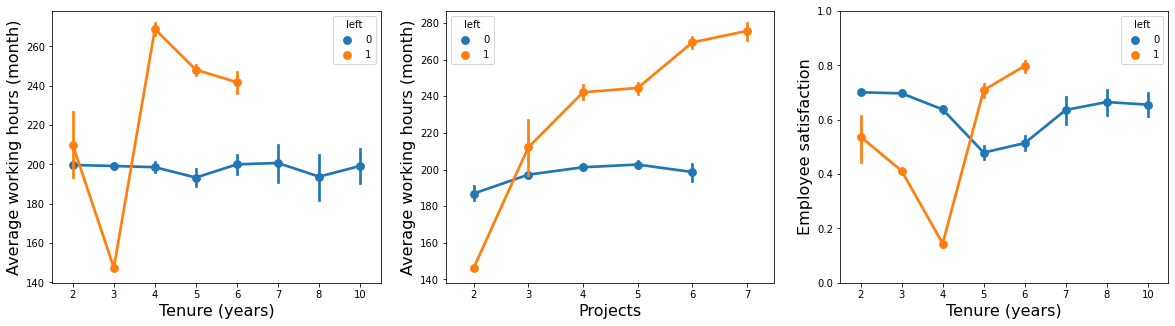

In [123]:
# WORKING HOURS, SATISFACTION, EVALUATION
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (20,5))
gs = plt.GridSpec(1,3)

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])

ax1 = sns.pointplot(ax=g1, data=df1, x='tenure', y='av_hours_month', hue='left')
ax1.set_xlabel('Tenure (years)', fontsize=16)
ax1.set_ylabel('Average working hours (month)', fontsize=16)

ax2 = sns.pointplot(ax=g2, data=df1, x='projects', y='av_hours_month', hue='left')
ax2.set_xlabel('Projects', fontsize=16)
ax2.set_ylabel('Average working hours (month)', fontsize=16)

ax3 = sns.pointplot(ax=g3, data=df1, x='tenure', y='satisfaction', hue='left')
ax3.set_xlabel('Tenure (years)', fontsize=16)
ax3.set_ylabel('Employee satisfaction', fontsize=16)
ax3.set_ylim(0,1)

fig.show()

<div class="alert alert-block alert-success">
<b>Working hours, tenure, projects:</b>

* Workers who stay manage to keep constant average work hours throughout the years, regardless of number of projects.
    * Their satisfaction dips around 0.2 points at years five and six.
* Workers who leave have slightly lower satisfaction levels already at year 2.
    * Their average work hours fall about 60h/month at year three, and then raise 120h/month at year four.
    * Work load is proportional to number of assigned projects.
    * Satisfaction dips drastically with sudden increase of work load at year 4, only to then raise abouve the level of workers who stay.
</div>

<ipython-input-124-97087aa86f27>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


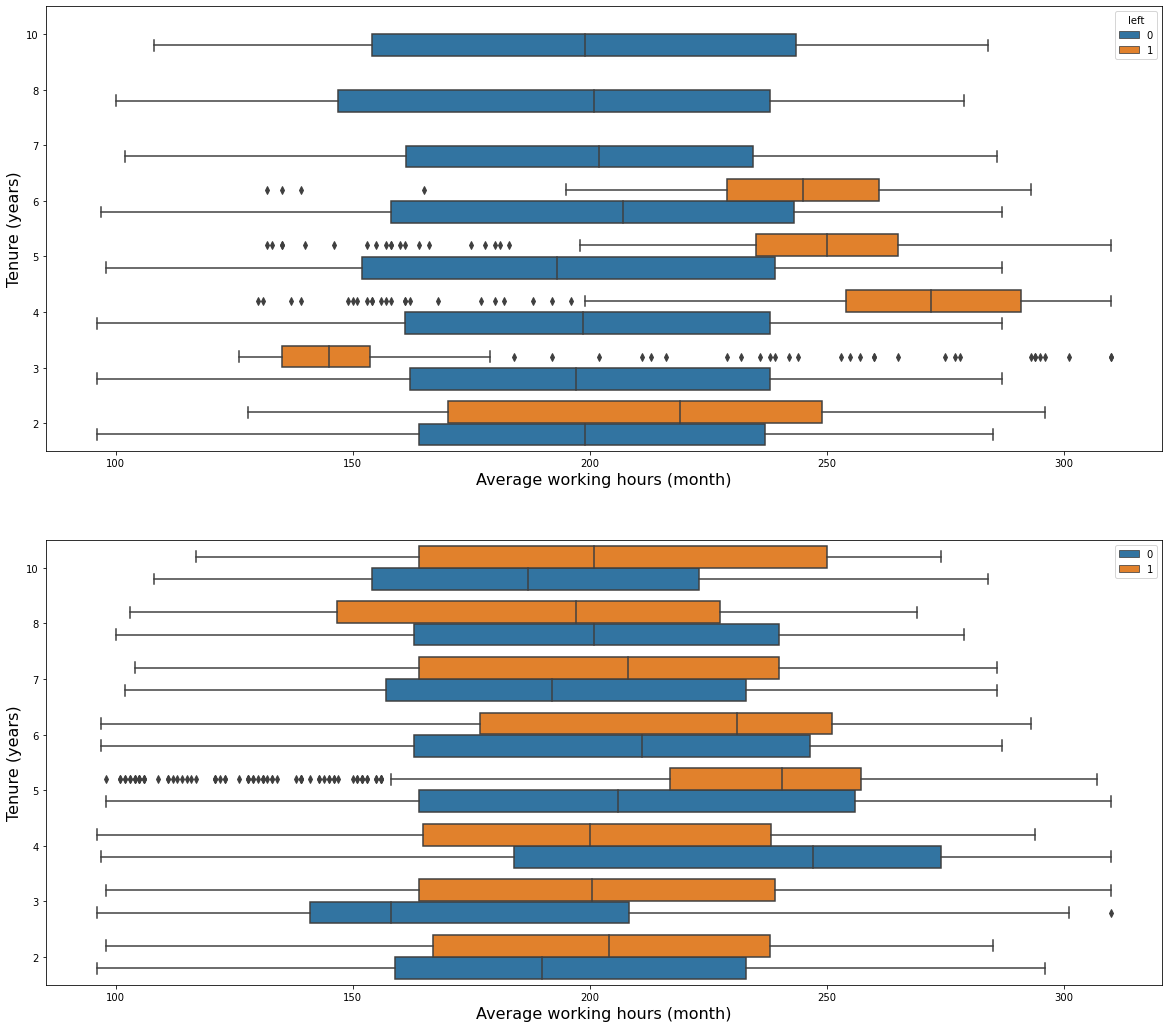

In [124]:
# WORKING HOURS, SATISFACTION, EVALUATION
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (20,18))
gs = plt.GridSpec(2,1)

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0])
g2 = plt.subplot(gs[1])

ax1 = sns.boxplot(ax=g1, data = df1, x='av_hours_month', y = 'tenure', hue = 'left', orient='h')
ax1.invert_yaxis()
ax1.set_xlabel('Average working hours (month)', fontsize=16)
ax1.set_ylabel('Tenure (years)', fontsize=16)

ax2 = sns.boxplot(ax=g2, data = df1, x='av_hours_month', y = 'tenure',
                  hue = [1 if i > 0.6 else 0 for i in df1['satisfaction']], orient='h')
ax2.invert_yaxis()
ax2.set_xlabel('Average working hours (month)', fontsize=16)
ax2.set_ylabel('Tenure (years)', fontsize=16)

fig.show()

<div class="alert alert-block alert-success">
<b>Working hours, tenure, satisfaction:</b>
    
* Workers who leave tend to work larger hours to the extent of over-working (medians are almost universally between 200 and 250 hours per month). <br>
* Workers who are more satisfied tend to work larger hours (again, over-worked).
</div>

<ipython-input-125-ed65b5b3e151>:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


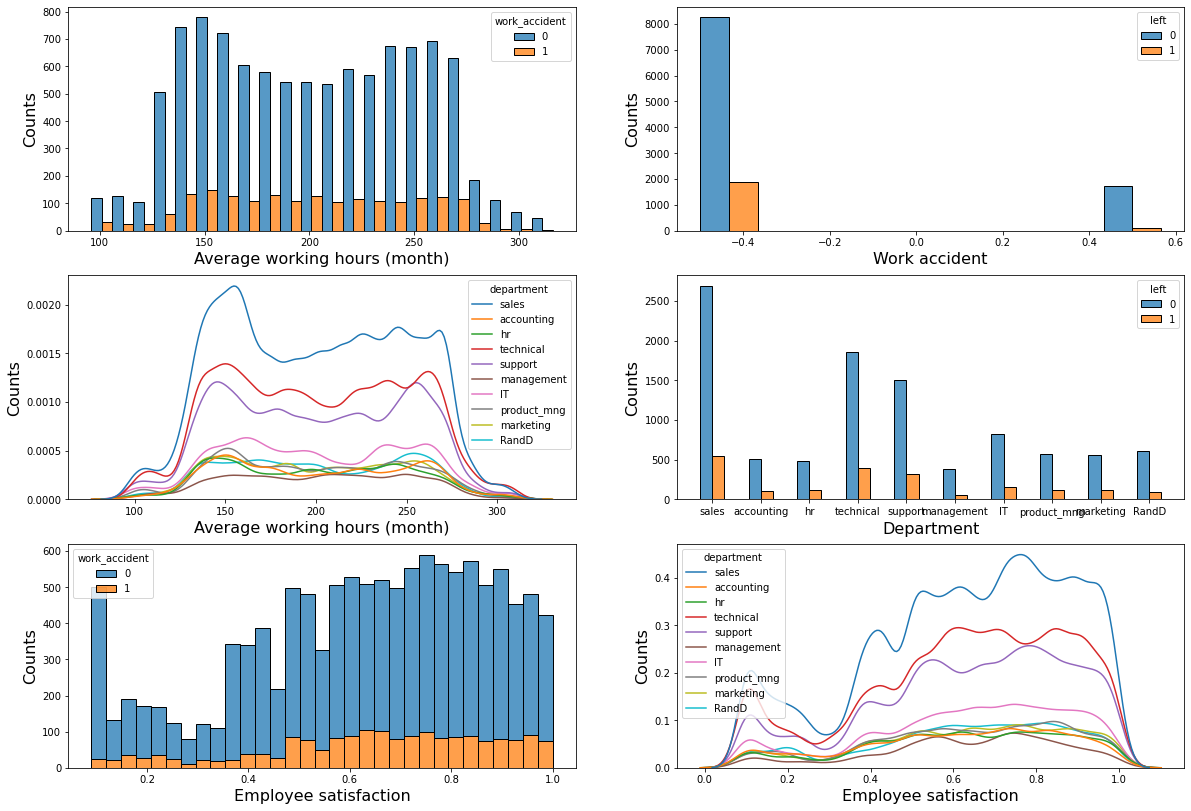

In [125]:
# ACCIDENTS, DEPARTMENT
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (20,14))
gs = plt.GridSpec(3,2)

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[1, 0])
g4 = plt.subplot(gs[1, 1])
g5 = plt.subplot(gs[2, 0])
g6 = plt.subplot(gs[2, 1])

ax1 = sns.histplot(ax=g1, data = df1, x='av_hours_month',hue = 'work_accident', stat='count', multiple='dodge', binwidth=10)
ax1.set_xlabel('Average working hours (month)', fontsize=16)
ax1.set_ylabel('Counts', fontsize=16)

ax2 = sns.histplot(ax=g2, data = df1, x=df1['work_accident'].astype(int),hue = 'left', stat='count', multiple='dodge', shrink=2)
ax2.set_xlabel('Work accident', fontsize=16)
ax2.set_ylabel('Counts', fontsize=16)

ax3 = sns.kdeplot(ax=g3, data = df1, x='av_hours_month',hue = 'department', bw_adjust=0.5)
ax3.set_xlabel('Average working hours (month)', fontsize=16)
ax3.set_ylabel('Counts', fontsize=16)

ax4 = sns.histplot(ax=g4, data = df1, x='department',hue = 'left', stat='count', multiple='dodge', shrink=0.5)
ax4.set_xlabel('Department', fontsize=16)
ax4.set_ylabel('Counts', fontsize=16)

ax5 = sns.histplot(ax=g5, data = df1, x='satisfaction',hue = 'work_accident', stat='count', multiple='stack')
ax5.set_xlabel('Employee satisfaction', fontsize=16)
ax5.set_ylabel('Counts', fontsize=16)

ax6 = sns.kdeplot(ax=g6, data = df1, x='satisfaction',hue = 'department', bw_adjust=0.5)
ax6.set_xlabel('Employee satisfaction', fontsize=16)
ax6.set_ylabel('Counts', fontsize=16)

fig.show()

<div class='alert alert-block alert-success'>
<b>Accidents, department:</b>

* Probability of working accidents is independent of workload. Employees who do suffer accidents are much less likely to leave.
* Sales, technical, management and IT seem to have a bimodal distribution of work hours and satisfaction, most obvious in Sales.
* Sales, technical and support are the departments whose workers are most likely to leave.
</div>

<ipython-input-126-cef9e7eec7fe>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


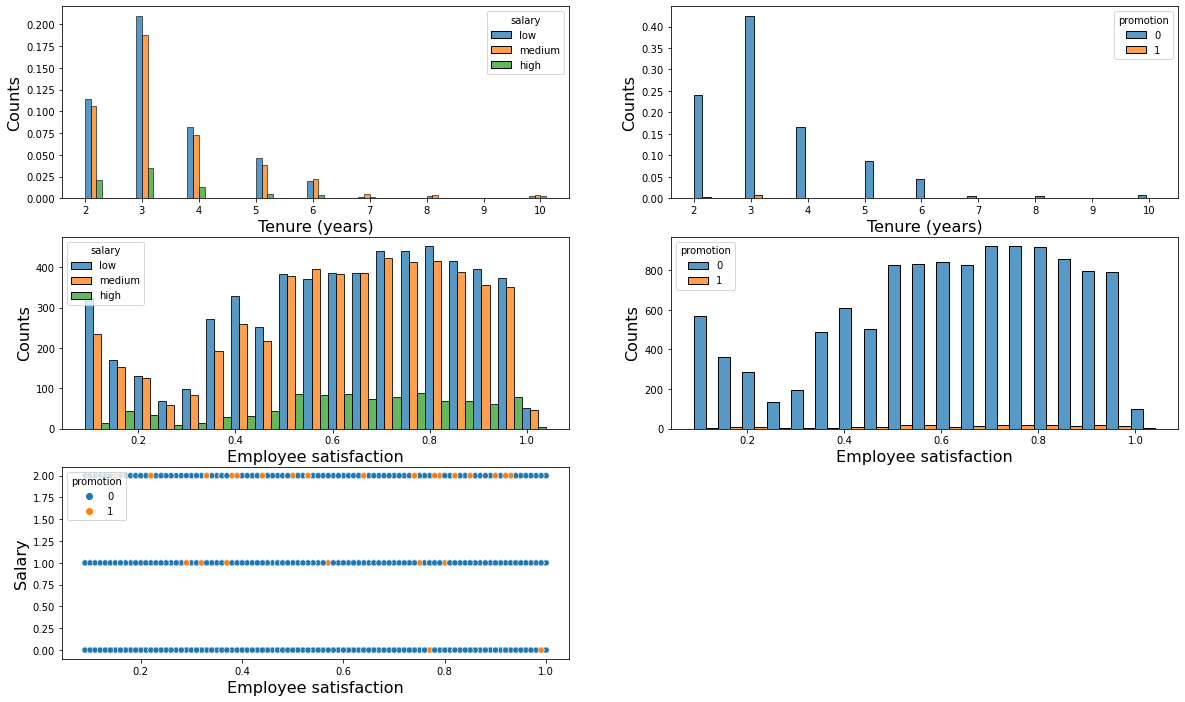

In [126]:
# WORKING HOURS, SATISFACTION, EVALUATION
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (20,12))
gs = plt.GridSpec(3,2)

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[1, 0])
g4 = plt.subplot(gs[1, 1])
g5 = plt.subplot(gs[2, 0])

ax1 = sns.histplot(ax=g1, data=df1, x='tenure', hue='salary', stat='probability', multiple='dodge', binwidth=0.3)
ax1.set_xlabel('Tenure (years)', fontsize=16)
ax1.set_ylabel('Counts', fontsize=16)

ax2 = sns.histplot(ax=g2, data=df1, x='tenure', hue='promotion', stat='probability', multiple='dodge', binwidth=0.3)
ax2.set_xlabel('Tenure (years)', fontsize=16)
ax2.set_ylabel('Counts', fontsize=16)

ax3 = sns.histplot(ax=g3, data=df1, x='satisfaction', hue='salary', stat='count', multiple='dodge', binwidth=0.05)
ax3.set_xlabel('Employee satisfaction', fontsize=16)
ax3.set_ylabel('Counts', fontsize=16)

ax4 = sns.histplot(ax=g4, data=df1, x='satisfaction', hue='promotion', stat='count', multiple='dodge', binwidth=0.05)
ax4.set_xlabel('Employee satisfaction', fontsize=16)
ax4.set_ylabel('Counts', fontsize=16)

ax5 = sns.scatterplot(ax=g5, data=df1, x='satisfaction', 
                  y=[0 if i == 'low' else 1 if i == 'medium' else 2 for i in df1['salary']],
                  hue='promotion')
ax5.set_xlabel('Employee satisfaction', fontsize=16)
ax5.set_ylabel('Salary', fontsize=16)

fig.show()

<div class= 'alert alert-block alert-success'>
<b>Promotion, Salary:</b>
    
* Promotions and salary do not appear to be good predictors.
</div>

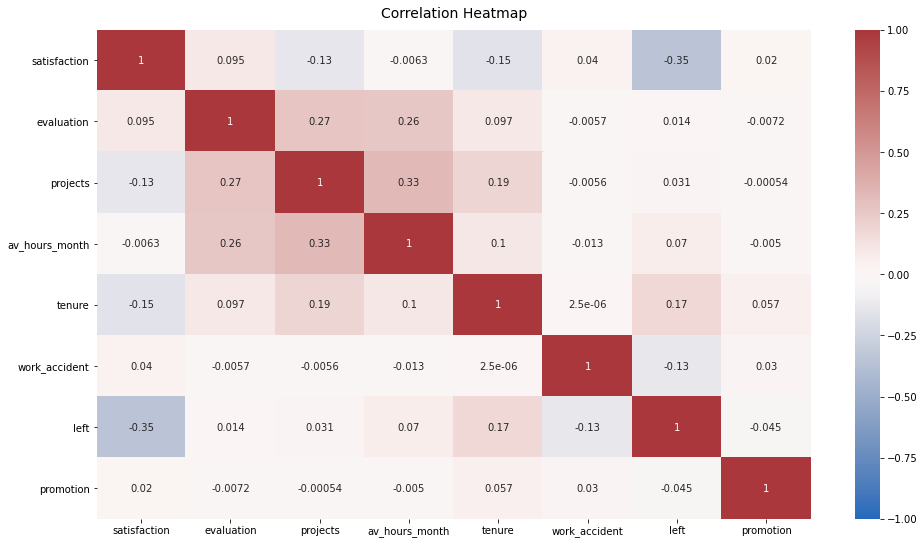

In [127]:
# CORRELATION HEATMAP
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

<div class= 'alert alert-block alert-success'>
<b>Correlation between variables:</b>

* As observed, PROJECTS, AV_HOURS_MONTH and EVALUATION are positively correlated.
* TENURE is slightly positively correlated with PROJECTS and LEFT.
* SATISFACTION is negatively correlated with LEFT.
</div>

<div class= 'alert alert-block alert-info'>
<b>Choosing variables for final model:</b>

* Either PROJECTS, AV_HOURS_MONTH or EVALUATION should be used to build a regression model, or a new variable extracted from them.
* TENURE AND SATISFACTION should be used in building the model.
</div>

# Modeling

<div class = 'alert alert-block alert-info'>
<b>A LOGISTIC REGRESSION model will be built using:</b>
    
* TENURE (int)
* SATISFACTION (float)
* AV_HOURS_MONTH (int)
* PROJECTS (int)
* EVALUATION (float)
    
To predict LEFT (int).<br>
***
<b>The idea is to keep it simple, no fuss, and check how it works</b>
</div>

In [128]:
### NEW DATA FRAME WITHOUT OUTLIERS ###
df_lg_short = df_nofliers.copy()

# DROPPING UNNECESSARY COLUMNS
df_lg_short.drop(['work_accident', 'promotion', 'department', 'salary'], axis=1, inplace = True)
df_lg_short.head()

,satisfaction,evaluation,projects,av_hours_month,tenure,left
0,0.38,0.53,2,157,3,1
2,0.11,0.88,7,272,4,1
3,0.72,0.87,5,223,5,1
4,0.37,0.52,2,159,3,1
5,0.41,0.50,2,153,3,1


<div class = 'alert alert-block alert-warning'>
<b>Training and validation:</b>

There are only 11k entries in the dataset.<br>
No data will be reserved for independent validation (apart from cross-validation). 
</div>

<div class = 'alert alert-block alert-info'>
<b>Prepare data for model:</b>:

* training data (4 cross-validation folds)
* test data (25% of total data)
* stratify data according to outcome distribution
* scale data (standardization)
</div>

In [129]:
# SEPARATE PREDICTOR AND OUTCOME VARIABLES
y = df_lg_short['left']
X = df_lg_short.drop('left', axis=1)

# SEPARATE TRAINING AND TEST DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
# SCALE THE PREDICTOR FEATURES TO A NORMAL DISTRIBUTION
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# TRANSFORM SCALED SETS BACK TO DATAFRAME FORMAT
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [130]:
# SETUP MODEL, CROSS-VALIDATION
lg_model = LogisticRegressionCV(Cs = 10, cv = 4, scoring = 'f1', max_iter = 500, refit='f1')
# FIT MODEL
lg_model.fit(X_train, y_train)

LogisticRegressionCV(cv=4, max_iter=500, refit='f1', scoring='f1')

<div class='alert alert-block alert-info'>
Because the features have been standardized, odds can be directly compared by simply exponentiating the regression coefficients.
<div>

<ipython-input-131-e410ecf00e2d>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_odd.show()


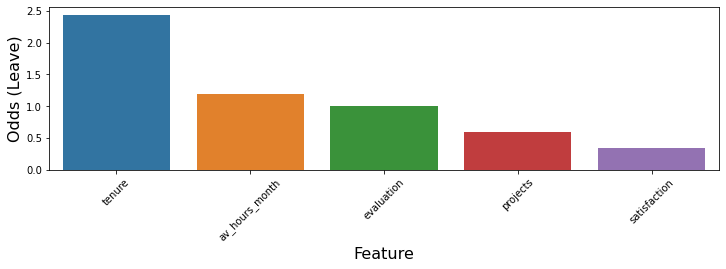

In [131]:
# EXCESS ODDS FROM LOGISTIC REGRESSION
fig_odd = plt.figure(figsize = (12,3))
odds = pd.DataFrame()
odds['Feature'] = X_train.columns
odds['Odds'] = (np.exp(lg_model.coef_.flatten()))
odds = odds.sort_values(by = 'Odds', ascending=False, key=abs)
ax=sns.barplot(data=odds, x='Feature', y='Odds')
ax.set_xlabel('Feature', fontsize=16)
ax.set_ylabel('Odds (Leave)', fontsize=16)
plt.xticks(rotation = 45)        
fig_odd.show()

<div class = 'alert alert-block alert-success'>
<b>Feature Importance:</b>
    
TENURE is predicted to be the most important feature, with an odds factor twice as large as the next two positive features, AV_HOURS_MONTH and EVALUATION.<br>

Larger TENURE, AV_HOURS_MONTH, or EVALUATION increase the odds of an employee leaving.
Larger SATISFACTION or PROJECTS decrease the odds of en employee leaving.
<div>

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.94      0.90      2321
    Predicted would leave       0.45      0.23      0.31       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.59      0.60      2792
             weighted avg       0.79      0.82      0.80      2792



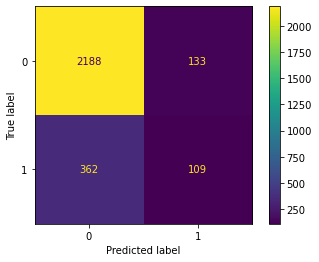

In [132]:
# MAKE PREDICTIONS ON TEST DATA
preds = lg_model.predict(X_test)
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, preds, target_names=target_names))
# PLOT CONFUSION MATRIX
cm_logreg = confusion_matrix(y_test, preds, labels = lg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_logreg, display_labels=lg_model.classes_)
disp.plot(values_format='')
plt.show()

<div class = 'alert alert-block alert-success'>
<b>Confusion Matrix and Scores:</b>
    
The model behaves well at predicting which employees are staying, much worse in predicting those who leave.<br>
False positives are comparble to true positives (the prediction of interest).<br>
False negatives are threefold true positives.<br>
<div>

In [133]:
# CHECK FOR CLASS IMBALANCE
y_test.value_counts()/y_test.count()

0    0.831304
1    0.168696
Name: left, dtype: float64

<div class = 'alert alert-block alert-warning'>
<b>Possible Issues:</b>
    
* Classes are imbalanced: the target class only includes 17% of the data, 23% of which is correctly predicted
* Data for employees that left seemed too tightly packed
* PROJECTS, AV_HOURS_MONTH and EVALUATION are correlated, and there's something weird about their coefficients (e.g., PROJECTS decreases the probability of leaving, when the data suggests workers leave due to being overworked)
<div>

<div class = 'alert alert-block alert-info'>
<b>ANOTHER LOGISTIC REGRESION CLASSIFIER will be built using:</b>
    
* TENURE (int)
* SATISFACTION (float)
* AV_HOURS_MONTH (int)
    
To predict LEFT (int).<br>
***
<b>Again, the idea is to keep it simple, no fuss, and get rid of correlated features</b><br>
</div>

In [134]:
# ELIMINATE CORRELATED FEATURES FROM DATASET
X_train2 = X_train.drop(['projects', 'evaluation'], axis=1)
X_test2 = X_test.drop(['projects', 'evaluation'], axis=1)
# SETUP MODEL, CROSS-VALIDATION
# CV PARAMETERS
lg_model2 = LogisticRegressionCV(Cs = 10, cv = 4, scoring = 'f1', max_iter = 500, refit='f1')
# FIT MODEL
lg_model2.fit(X_train2, y_train)

LogisticRegressionCV(cv=4, max_iter=500, refit='f1', scoring='f1')

<ipython-input-135-0e3788c33a32>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_odd.show()


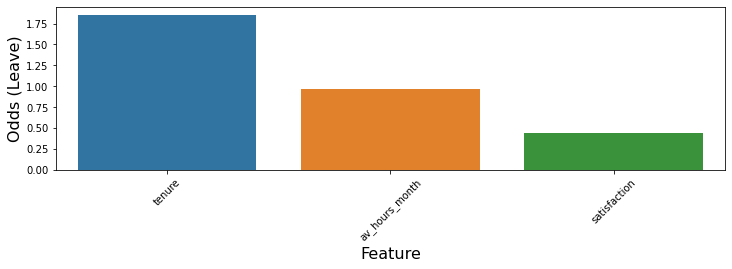

In [135]:
# EXCESS ODDS FROM LOGISTIC REGRESSION
fig_odd = plt.figure(figsize = (12,3))
odds = pd.DataFrame()
odds['Feature'] = X_train2.columns
odds['Odds'] = (np.exp(lg_model2.coef_.flatten()))
odds = odds.sort_values(by = 'Odds', ascending=False, key=abs)
ax=sns.barplot(data=odds, x='Feature', y='Odds')
ax.set_xlabel('Feature', fontsize=16)
ax.set_ylabel('Odds (Leave)', fontsize=16)
plt.xticks(rotation = 45)        
fig_odd.show()

                           precision    recall  f1-score   support

Predicted would not leave       0.87      0.94      0.90      2321
    Predicted would leave       0.50      0.28      0.36       471

                 accuracy                           0.83      2792
                macro avg       0.68      0.61      0.63      2792
             weighted avg       0.80      0.83      0.81      2792



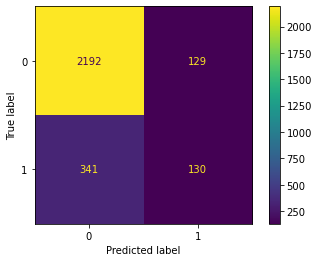

In [136]:
# MAKE PREDICTIONS ON TEST DATA
preds2 = lg_model2.predict(X_test2)
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, preds2, target_names=target_names))
# PLOT CONFUSION MATRIX
cm_logreg = confusion_matrix(y_test, preds2, labels = lg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_logreg, display_labels=lg_model.classes_)
disp.plot(values_format='')
plt.show()

<div class = 'alert alert-block alert-warning'>
The model improved a little, but it's still rubbish for predicting which employees leave.
<div>

<div class = 'alert alert-block alert-info'>
<b>A BOOSTED TREE model (XGB) will be built using:</b>
    
* all the data
    
To predict LEFT (int).<br>
Trees don't care about scaling, outliers, and so on, so we'll use the whole dataset.<br>
We do, however, need to encode the DEPARTMENT and SALARY features.
***
<b>The idea is to keep it simple, no fuss, and make something that works</b><br>
The other idea is that the LOGREG didn't properly predict probability of leaving and random forests should perform worse than boosted trees for classification.
</div>

In [137]:
df2 = pd.get_dummies(data=df1)

In [138]:
# SPLITTING THE DATA
df_xgb = df2.copy()
Xt = df_xgb.drop('left', axis=1)
yt = df_xgb['left']
# TRAIN, TEST SETS
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.25, stratify=yt, random_state=0)

In [139]:
# SET-UP CROSS-VALIDATION AND MODEL
# MODEL
xtree = XGBClassifier(objective = 'binary:logistic')
# PARAMS
cv_params = {'max_depth' : [4, 6, 8],
            'n_estimators' : [75, 100, 125],
            'learning_rate' : [0.1, 0.2, 0.3],
            'colsample_bytree' : [0.6, 0.8, 1.0],
            'min_child_weight': [1, 5, 10],
            'subsample' : [0.4, 0.6, 0.8]}
#SCORE
scores = {'f1', 'accuracy', 'recall', 'precision'}
# CROSS-VALIDATION
xtree_cv = GridSearchCV(estimator = xtree, cv=4, param_grid=cv_params, scoring=scores, refit='f1')

In [140]:
%%time
# FIT MODEL WITH CROSS-VALIDATION
#xtree_cv.fit(Xt_train, yt_train)

Wall time: 0 ns


In [141]:
print(xtree_cv.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
# BEST ESTIMATOR
model_xgb_opt = XGBClassifier(colsample_bytree = 1.0, learning_rate=0.1, max_depth = 8,
                                min_child_weight = 1, n_estimators = 75, subsample = 0.8, random_state = 0,
                             objective = 'binary:logistic')
model_xgb_opt.fit(Xt_train, yt_train)
tpreds = model_xgb_opt.predict(Xt_test)
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(yt_test, tpreds, target_names=target_names))
# CONFUSION MATRIX
cm = confusion_matrix(yt_test, tpreds, labels=xtree_cv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xtree_cv.best_estimator_.classes_)
disp.plot(values_format='')
# FEATURE IMPORTANCE
fig = plt.figure(figsize=(20,12))

importance = pd.DataFrame()
importance['feature'] = Xt_test.columns
importance['gini_imp'] = xtree_cv.best_estimator_.feature_importances_
importance = importance.sort_values(by='gini_imp', ascending=False)

ax = sns.barplot(data=importance, x='gini_imp', y='feature', orient='h')
ax.set_xlabel('Gini importance', fontsize=16)
ax.set_ylabel('Feature', fontsize=16)

fig.show()

<div class='alert alert-block alert-success'>
The model is <b>bloody good</b>!<br>
Still... it incorrectly predicts 42 employees to stay and 7 to leave.
<div>